In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os

In [2]:
PATH= "data/Invasive Species/"
    
train_path = f'{PATH}train'
test_path = f'{PATH}test'

In [3]:
files = os.listdir(train_path)[:5]
files

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg']

In [4]:
train_labels_path = f'{PATH}train_labels.csv'
train_labels =  pd.read_csv(train_labels_path)

In [5]:
train_labels.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


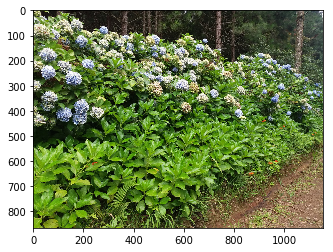

In [6]:
img = plt.imread(train_path + '/' + files[2])
plt.imshow(img)

In [7]:
img.shape

(866, 1154, 3)

In [8]:
img[:4, :4]

array([[[153, 179, 108],
        [112, 134,  61],
        [ 88, 102,  25],
        [ 90,  97,  19]],

       [[161, 184, 112],
        [ 92, 112,  40],
        [ 78,  90,  18],
        [ 97, 100,  29]],

       [[143, 165,  92],
        [ 81,  97,  26],
        [ 90,  99,  32],
        [152, 153,  93]],

       [[113, 134,  57],
        [ 81,  94,  24],
        [ 98, 104,  42],
        [208, 207, 153]]], dtype=uint8)

In [9]:
from fastai.imports import *

In [10]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [11]:
arch = resnet50
sz = 224
n = len(train_labels)
cv_idxs = get_cv_idxs(n)
bs = 64

In [12]:
data = ImageClassifierData.from_csv(PATH, folder = 'train', csv_fname = f'{PATH}train_labels.csv', 
                                   bs = bs, val_idxs = cv_idxs, tfms = tfms_from_model(arch, sz),
                                   suffix = '.jpg', test_name = 'test')

In [13]:
learn = ConvLearner.pretrained(arch, data, precompute = True)

100%|██████████| 24/24 [00:31<00:00,  1.32s/it]


In [39]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [15]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      2.072858   948.916016 0.758878  



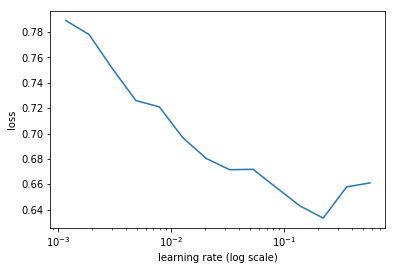

In [16]:
learn.sched.plot()

In [17]:
lr = 0.1
learn.fit(lr, 3, cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.558516   0.277062   0.904652  
    1      0.420026   0.205044   0.92223                   
    2      0.350061   0.250217   0.920277                  



[0.2502168, 0.9202769920229912]

In [18]:
lr = np.array([1e-3, 1e-2, 1e-1])

In [19]:
learn.unfreeze()

In [20]:
learn.fit(lr, 2, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.178564   0.237063   0.904652  
    1      0.193954   0.246379   0.920277                  
    2      0.162811   0.259967   0.914418                  



[0.25996727, 0.9144176170229912]

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [ ]:
probs[:5]

In [21]:
test_path = f'{PATH}/test'
test = os.listdir(test_path)

In [22]:
test[:5]

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg']

In [23]:
test_file = pd.DataFrame(test)

In [24]:
test_file['name'] = test_file[0].apply(lambda x: x.split('.')[0])

In [25]:
test_file = test_file.drop([0], axis = 1)

In [26]:
test_file.head()

,name
0,1
1,10
2,100
3,1000
4,1001


In [27]:
preds = learn.predict(is_test = True)

In [28]:
preds = np.exp(preds)

In [29]:
preds_df = pd.DataFrame(preds)

In [30]:
preds_df.head()

,0,1
0,0.019075,0.980925
1,0.999992,0.000008
2,0.957790,0.042210
3,0.999052,0.000948
4,0.999977,0.000024


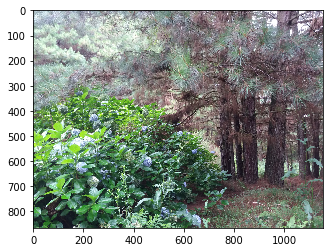

In [31]:
img = plt.imread(test_path + '/' + files[0])
plt.imshow(img)

In [32]:
preds_pos = preds_df.iloc[:, 1]
preds_pos.head()

0    0.980925
1    0.000008
2    0.042210
3    0.000948
4    0.000024
Name: 1, dtype: float32

In [33]:
sub = pd.concat([test_file, preds_pos], axis = 1)

In [34]:
sub.columns = ['name', 'invasive']

In [35]:
sub.head()

,name,invasive
0,1,0.980925
1,10,0.000008
2,100,0.042210
3,1000,0.000948
4,1001,0.000024


In [36]:
sub.to_csv('invasive species submission.csv', index = False)